In [1]:
import mosaik
import mosaik.util
from pv_configurations import generate_configurations, Scenarios
import simbench
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import pandapower as pp
import pandas as pd
import matplotlib
import nest_asyncio
import numpy as np


def getElementbyName(grid, name):
    """
    Get the element by name from the DataFrame.
    """
    for element in grid.children:
        if element.extra_info['name'] == name:
            return element
    return None    
#matplotlib.use("Qt5Agg")  # Use "Qt5Agg" if you have PyQt5 installed

# Simulator backends
SIM_CONFIG = {
    'ChargerSim': {        
        'python': 'mosaik_csv:CSV'
    },  
    # 'PVSim': {
    #     'python': 'mosaik_components.pv.photovoltaic_simulator:PVSimulator'
    # },
    'CSV_writer': {
        'python': 'mosaik_csv_writer:CSVWriter',
    },
    "Pandapower": {
        'python': 'mosaik_components.pandapower:Simulator'
    }
}

START = "2024-12-01 00:15:00"
END = 3600 * 72
STEP_SIZE = 60 * 15
CHARGER_DATA = "./dados-carregamento-normal.csv"

#this is needed to use mosaik on ipynbs
nest_asyncio.apply()

world = mosaik.World(SIM_CONFIG)


        ____                              _ _
       /    \                            (_) |
  ____/      \  _ __ ___   ___  ___  __ _ _| | __
 /    \      / | '_ ` _ \ / _ \/ __|/ _` | | |/ / 
/      \____/  | | | | | | (_) \__ \ (_| | |   <     
\      /    \  |_| |_| |_|\___/|___/\__,_|_|_|\_\    
 \____/      \____
 /    \      /    \    mosaik version:     3.3.3
/      \____/      \   mosaik API version: 3.0.12
\      /    \      /   Python version:     3.12.3
 \____/      \____/    OS:                 Linux-6.11.0-21-generic-x86_64-with-glibc2.39
      \      /         Documentation:      https://mosaik.readthedocs.io/en/3.3.3/
       \____/          Get in touch:       https://github.com/orgs/OFFIS-mosaik/discussions




Connect Simulators Together

In [2]:


#Configure charger component
charger_sim = world.start("ChargerSim", sim_start=START, datafile=CHARGER_DATA)
charger_model = charger_sim.Charger1.create(1)
#meteo_model = meteo_sim.Braunschweig.create(1)

# Create PV system
# pv_count = 5
# pv_config = {str(i) : generate_configurations(Scenarios.HOUSE) for i in range(pv_count)}
# pv_sim = world.start(
#             "PVSim",
#             start_date=START,
#             step_size=STEP_SIZE,
#             pv_data=pv_config,
#         )
# pv_model = pv_sim.PVSim.create(pv_count)

# Power data output to test
csv_sim_writer = world.start('CSV_writer', start_date = START,
                                        output_file='results.csv')
csv_writer = csv_sim_writer.CSVWriter(buff_size = STEP_SIZE)

#Instantiate the power network
# create empty net
pp_sim = world.start("Pandapower", step_size=90)

net = pp.from_json("example.json")

grid = pp_sim.Grid(net=net)

extra_info = pp_sim.get_extra_info()


loads = [e for e in grid.children if e.type == "Load"]    
buses = [e for e in grid.children if e.type == "Bus"] 
lines = [e for e in grid.children if e.type == "Line"] 


#connect a charger to B5
#charger1 = pp_sim.ControlledGen(bus=buses[1].extra_info['index'])
charger1 = pp_sim.ControlledGen(bus=getElementbyName(grid,'B5').extra_info['index'])
generators = [e for e in grid.children if e.type == "StaticGen"] 

#output load Powers
for load in loads:
    world.connect(load, csv_writer, "P[MW]")

#output bus powers
for bus in buses:
    world.connect(bus, csv_writer, "P[MW]")

#output line information
for line in lines:
    world.connect(line, csv_writer, "I[kA]")
    #world.connect(line, csv_writer, "Pin[MW]")
    # world.connect(line, csv_writer, "Pout[MW]")
    # world.connect(line, csv_writer, "Pout[MW]")
    # world.connect(line, csv_writer, "VmIn[pu]")
    # world.connect(line, csv_writer, "VmOut[pu]")
    # world.connect(line, csv_writer, "QIn[MVar]")
    # world.connect(line, csv_writer, "QOut[MVar]")

#connect charger csv file to charger connection
world.connect(charger_model[0],charger1, ("P[MW]","P[MW]"))

#plot charger power
world.connect(charger_model[0], csv_writer, "P[MW]")


2025-04-08 18:40:03.311 | INFO     | mosaik.scenario:start:311 - Starting "ChargerSim" as "ChargerSim-0" ...
2025-04-08 18:40:03.335 | INFO     | mosaik.scenario:start:311 - Starting "CSV_writer" as "CSV_writer-0" ...
2025-04-08 18:40:03.340 | INFO     | mosaik.scenario:start:311 - Starting "Pandapower" as "Pandapower-0" ...


Plot Network Topology

No or insufficient geodata available --> Creating artificial coordinates. This may take some time
/tmp/ipykernel_1191146/590515652.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


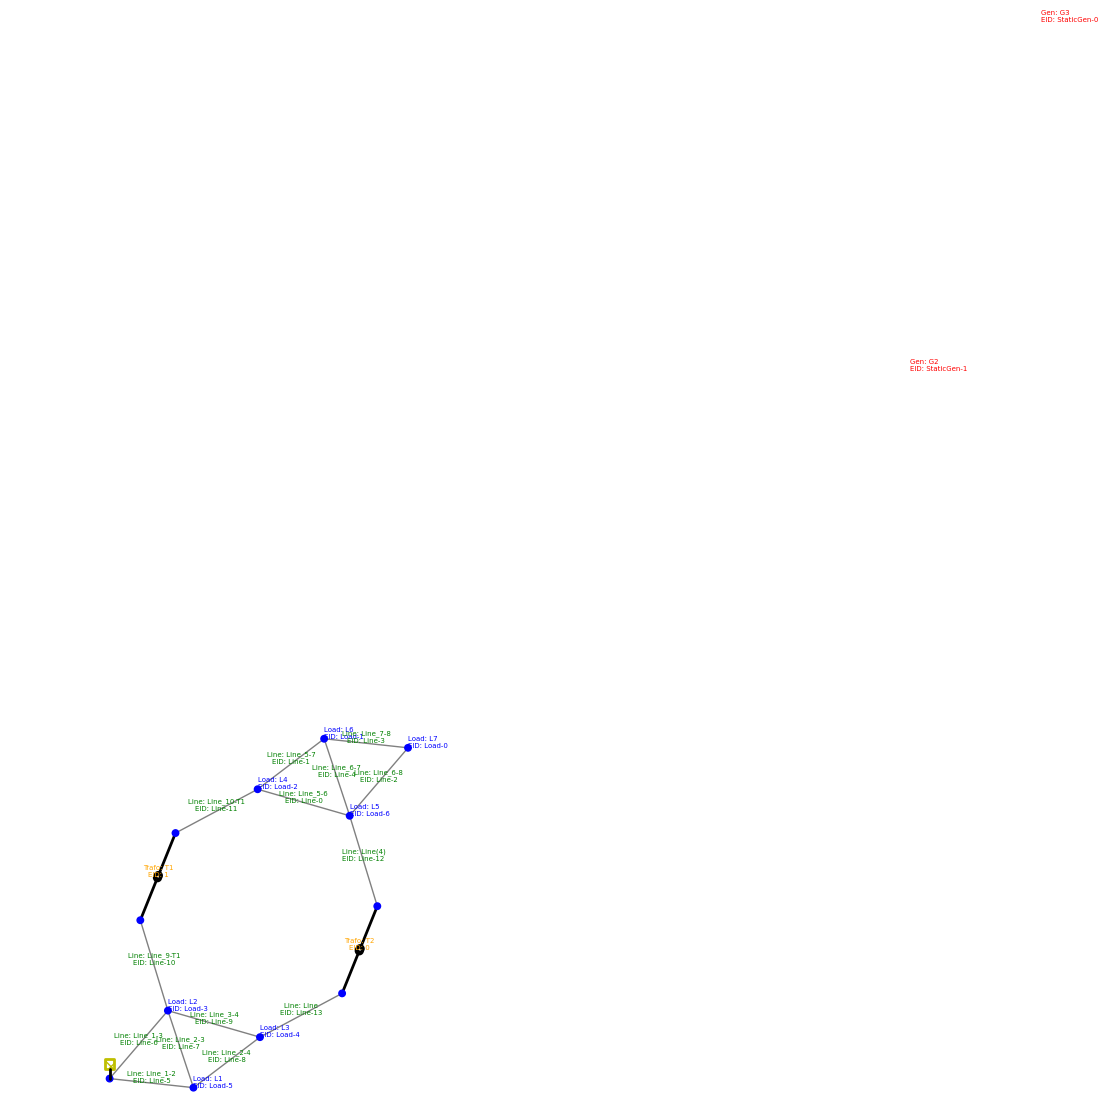

In [3]:
fig, ax = plt.subplots()
plot.simple_plot(net, ax=ax, show_plot=False)

# --- Annotate LOADS ---
for load in loads:
    load_data = net.load.iloc[load.extra_info['index']]
    x, y = net.bus_geodata.loc[load_data['bus'], ['x', 'y']]     
    ax.text(x, y, f'Load: {load_data['name']}\nEID: {load.eid}', fontsize=5, color='blue')

# --- Annotate LINES ---
for line in lines:
    line_data = net.line.iloc[line.extra_info['index']]
    fb, tb = line_data['from_bus'], line_data['to_bus']
    x1, y1 = net.bus_geodata.loc[fb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[tb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = line_data['name']
    ax.text(xm, ym, f'Line: {line_data['name']}\nEID: {line.eid}', fontsize=5, color='green', ha='center')

# --- Annotate TRANSFORMERS ---
for eid, trafo in net.trafo.iterrows():
    hb, lb = trafo.hv_bus, trafo.lv_bus
    x1, y1 = net.bus_geodata.loc[hb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[lb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = trafo['name']
    ax.text(xm, ym, f'Trafo: {name}\nEID: {eid}', fontsize=5, color='orange', ha='center')

# --- Annotate GENERATORS ---
for gen in generators:
    gen_data = net.sgen.iloc[gen.extra_info['index']]
    x, y = net.bus_geodata.loc[gen_data['bus'], ['x', 'y']]    
    ax.text(x + 5, y + 5, f'Gen: {gen_data['name']}\nEID: {gen.eid}', fontsize=5, color='red')

# --- Annotate SHUNTS ---
for eid, shunt in net.shunt.iterrows():
    bus = shunt.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = shunt['name'] 
    ax.text(x - 5, y - 5, f'Shunt: {name}\nEID: {eid}', fontsize=5, color='purple')

# --- Annotate STORAGE ---
for eid, storage in net.storage.iterrows():
    bus = storage.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = storage['name'] 
    ax.text(x + 5, y - 5, f'Storage: {name}\nEID: {eid}', fontsize=5, color='brown')

plt.tight_layout()
plt.savefig("topology.pdf")
plt.show()


Run the simulation

In [ ]:
 # Run simulation
    
world.run(until=END)

2025-04-08 16:56:36.080 | INFO     | mosaik.scenario:run:651 - Starting simulation.
100%|██████████| 259200/259200 [02:00<00:00, 2149.83steps/s] 
2025-04-08 16:58:36.660 | INFO     | mosaik.scenario:run:708 - Simulation finished successfully.


In [4]:
# Load the generated CSV file
filename = "results.csv"  # The original CSV file
output_filename = "resultsPowerFactoryLDF.csv"  # The new CSV file with renamed columns

# Load the CSV into a pandas DataFrame
df = pd.read_csv(filename)

# Rename the columns dynamically based on `lines[x].extra_info['name']`
# Assuming you have access to the `lines` list and their `extra_info` here
column_mapping = {}
for line in lines:
    line_name = line.extra_info.get('name', line.eid)
    column_mapping[f"Pandapower-0.{line.eid}-I[kA]"] = f"{line_name}_I[kA]"
    column_mapping[f"Pandapower-0.{line.eid}-Pin[MW]"] = f"{line_name}_Pin[MW]"
    column_mapping[f"Pandapower-0.{line.eid}-Pout[MW]"] = f"{line_name}_Pout[MW]"
    column_mapping[f"Pandapower-0.{line.eid}-VmIn[pu]"] = f"{line_name}_VmIn[pu]"
    column_mapping[f"Pandapower-0.{line.eid}-VmOut[pu]"] = f"{line_name}_VmOut[pu]"
    column_mapping[f"Pandapower-0.{line.eid}-QIn[MVar]"] = f"{line_name}_QIn[MVar]"
    column_mapping[f"Pandapower-0.{line.eid}-QOut[MVar]"] = f"{line_name}_QOut[MVar]"

for load in loads:
    load_name = load.extra_info.get('name', load.eid)
    column_mapping[f"Pandapower-0.{load.eid}-P[MW]"] = f"{load_name}_P[MW]"

for bus in buses:
    bus_name = load.extra_info.get('name', bus.eid)
    column_mapping[f"Pandapower-0.{bus.eid}-P[MW]"] = f"{bus_name}_P[MW]"


# Apply the column renaming
df.rename(columns=column_mapping, inplace=True)

# Save the updated DataFrame to a new CSV file
df.to_csv(output_filename, index=False)

print(f"Renamed CSV saved as {output_filename}")
    


Renamed CSV saved as resultsPowerFactoryLDF.csv


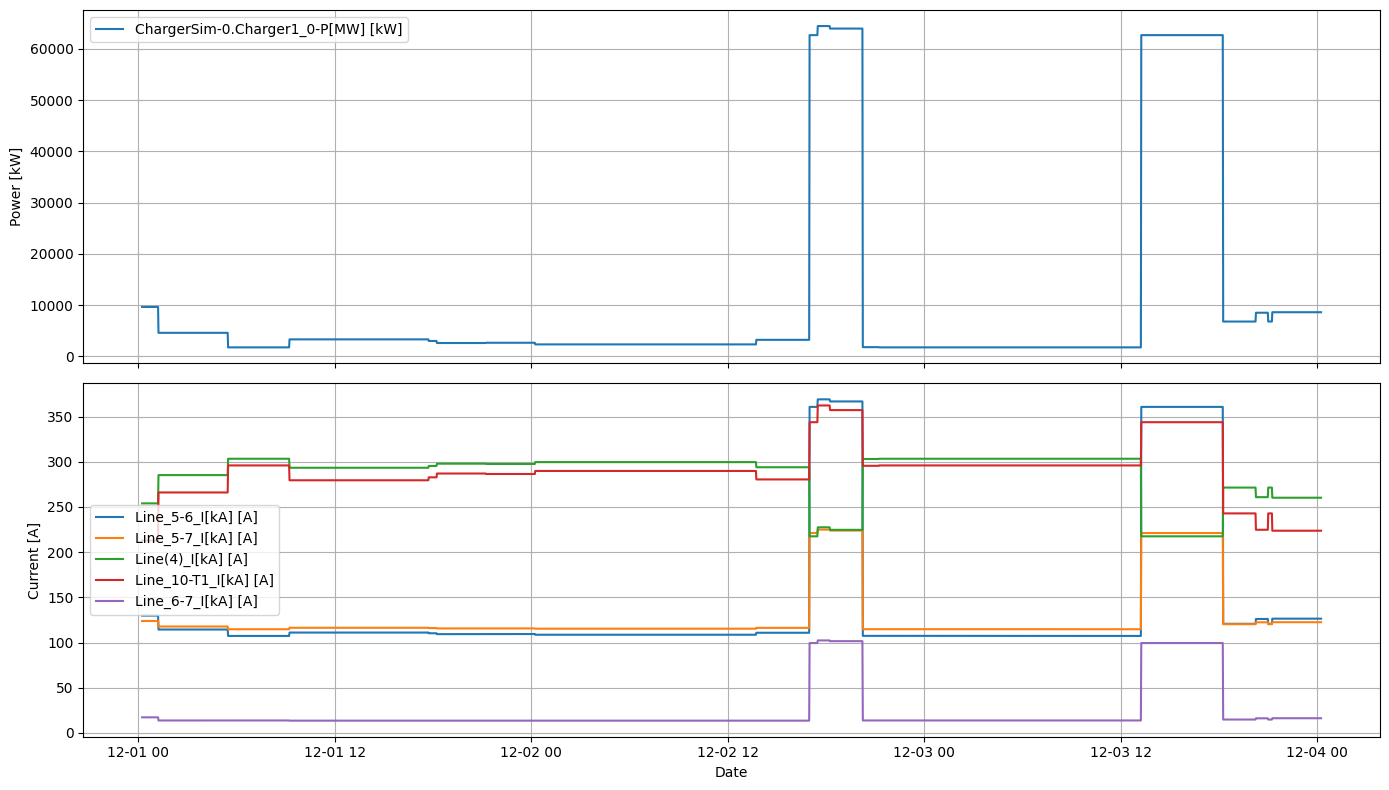

In [ ]:
# Load the CSV file
filename = "resultsPowerFactoryLDF.csv"
df = pd.read_csv(filename)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract power and current columns (assuming their naming convention includes 'P' or 'I')
#power_columns = [col for col in df.columns if "P[MW]" in col]
#current_columns = [col for col in df.columns if "I[kA]" in col]

power_columns = ["ChargerSim-0.Charger1_0-P[MW]"]

current_columns = ['Line_5-6_I[kA]', 'Line_5-7_I[kA]', 'Line(4)_I[kA]','Line_10-T1_I[kA]','Line_6-7_I[kA]']

# # Prepare subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# # Plot Power in kW
for column in power_columns:
     axs[0].plot(df['date'], df[column] * 1000, label=f"{column} [kW]")
axs[0].set_ylabel("Power [kW]")
axs[0].legend()


# # Plot Current in A
for column in current_columns:
     axs[1].plot(df['date'], df[column] * 1000, label=f"{column} [A]")
axs[1].set_ylabel("Current [A]")
axs[1].set_xlabel("Date")
axs[1].legend()    

# Add grid and adjust layout
for ax in axs.flat:
    ax.grid(True)
plt.tight_layout()

# Save the plot to a file
plt.savefig("results_subplots.pdf")
plt.show()

In [5]:
# Assuming you have net.line and net.bus as DataFrames
# First, merge for from_bus
lines_with_buses = net.line.merge(
    net.bus[['name']], left_on='from_bus', right_index=True, suffixes=('', '_from')
)

# Then, merge for to_bus
lines_with_buses = lines_with_buses.merge(
    net.bus[['name']], left_on='to_bus', right_index=True, suffixes=('', '_to')
)

# Rename the columns for clarity
lines_with_buses = lines_with_buses.rename(columns={
    'name': 'line_name',
    'name_from': 'from_bus_name',
    'name_to': 'to_bus_name'
})

# Optional: select and show desired columns
result = lines_with_buses[['line_name', 'from_bus_name', 'to_bus_name']]
print(result)

     line_name from_bus_name to_bus_name
0     Line_5-6            B5          B6
12     Line(4)           B12          B6
1     Line_5-7            B5          B7
4     Line_6-7            B6          B7
11  Line_10-T1            B5         B10
2     Line_6-8            B6          B8
3     Line_7-8            B7          B8
5     Line_1-2            B1          B2
6     Line_1-3            B1          B3
7     Line_2-3            B2          B3
8     Line_2-4            B2          B4
9     Line_3-4            B3          B4
13        Line           B11          B4
10   Line_9-T1            B3          B9
